### CNN

### Import libraries

In [7]:


import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential, Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lynxx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lynxx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Preprocessing module

In [2]:
# Define stop_words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [3]:
def preprocess_text(text):
    text = text.lower() # convert text to lowercase
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)  # replace "U.S." or "US" with "usa"
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers and punctuation (keep only letters and spaces)
    words = text.split()
    words = [word for word in words if word not in stop_words] # remove stop-words, tokenization
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return ' '.join(words) # combining words into a string

In [4]:
# Loading the data
train_df = pd.read_csv('../data/agn_train.csv')
test_df = pd.read_csv('../data/agn_test.csv')

In [5]:
%%time

# Applying preprocessing to titles and descriptions
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization
tokenizer = Tokenizer(num_words=5000)  # Limit the number of words
tokenizer.fit_on_texts(train_df['clean_text'])  # Tokenize based on the training data

# Tokenizing titles and descriptions
X_train_title_seq = tokenizer.texts_to_sequences(train_df['Title'])
X_test_title_seq = tokenizer.texts_to_sequences(test_df['Title'])

X_train_description_seq = tokenizer.texts_to_sequences(train_df['Description'])
X_test_description_seq = tokenizer.texts_to_sequences(test_df['Description'])

# Determine the maximum sequence length
max_length_titles = max([len(x) for x in X_train_title_seq])
max_length_descriptions = max([len(x) for x in X_train_description_seq])

# Padding sequences to make them of equal length
X_train_title_pad = pad_sequences(X_train_title_seq, maxlen=max_length_titles)
X_test_title_pad = pad_sequences(X_test_title_seq, maxlen=max_length_titles)

X_train_description_pad = pad_sequences(X_train_description_seq, maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(X_test_description_seq, maxlen=max_length_descriptions)

# Assign labels for the training data
y_train = train_df['Class Index'].values - 1  # Adjust class indices to [0, 1, 2, 3]

# Assign labels for the test data
y_test = test_df['Class Index'].values - 1  # Adjust class indices to [0, 1, 2, 3]

# Loading pre-trained GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Creating an embedding matrix for the words in the tokenizer
embedding_matrix = np.zeros((5000, 100))  # input_dim=5000, output_dim=100 (GloVe vector size)
for word, i in tokenizer.word_index.items():
    if i < 5000:  # Only use the top 5000 words
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Using pre-trained GloVe embeddings
embedding_layer = Embedding(input_dim=5000, 
                            output_dim=100, 
                            weights=[embedding_matrix],  # Passing the pre-trained embedding matrix
                            trainable=False)  # Embeddings are not trainable

CPU times: total: 25.2 s
Wall time: 35.4 s


### Training module

In [10]:
%%time

# Input for titles
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)(title_input)
title_conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(title_embedding)  # Convolutional layer
title_maxpool = MaxPooling1D(pool_size=2)(title_conv1d)  # Max pooling layer
title_flatten = Flatten()(title_maxpool)  # Flatten the output

# Input for descriptions
description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)(description_input)
description_conv1d = Conv1D(filters=128, kernel_size=3, activation='relu')(description_embedding)  # Convolutional layer
description_maxpool = MaxPooling1D(pool_size=2)(description_conv1d)  # Max pooling layer
description_flatten = Flatten()(description_maxpool)  # Flatten the output

# Merge the outputs from both title and description inputs
merged = Concatenate()([title_flatten, description_flatten])

# Fully connected layers after merging
dense_1 = Dense(128, activation='relu')(merged)  # First dense layer
dense_2 = Dense(64, activation='relu')(dense_1)  # Second dense layer
output = Dense(4, activation='softmax')(dense_2)  # Output layer with 4 classes (multi-class classification)

# Build the model
model = Model(inputs=[title_input, description_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model with early stopping
# Correct input structure: List of inputs
model.fit([X_train_title_pad, X_train_description_pad],  # List of inputs
          y_train, 
          validation_split=0.1, epochs=10, batch_size=32, verbose=1, 
          callbacks=[early_stopping])

Epoch 1/10
1070/3375 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8263 - loss: 0.4817

KeyboardInterrupt: 

### Hyperparameter selection module

In [12]:
%%time

# Defining hyperparameters with Optuna
def model_builder(trial):
    # Hyperparameters to optimize
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_units = trial.suggest_int('num_units', 64, 512)
    filters = trial.suggest_int('filters', 64, 256)  # Number of filters for Conv1D
    kernel_size = trial.suggest_int('kernel_size', 3, 5)  # Kernel size for Conv1D

    # Input for titles
    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = Embedding(input_dim=5000, output_dim=100, 
                                weights=[embedding_matrix], trainable=False)(title_input)
    title_conv1d = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(title_embedding)
    title_maxpool = MaxPooling1D(pool_size=2)(title_conv1d)
    title_flatten = Flatten()(title_maxpool)

    # Input for descriptions
    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = Embedding(input_dim=5000, output_dim=100, 
                                      weights=[embedding_matrix], trainable=False)(description_input)
    description_conv1d = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(description_embedding)
    description_maxpool = MaxPooling1D(pool_size=2)(description_conv1d)
    description_flatten = Flatten()(description_maxpool)

    # Merging the title and description representations
    merged = Concatenate()([title_flatten, description_flatten])
    
    # Fully connected layers
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)  # 4 classes

    # Create the model
    model = Model(inputs=[title_input, description_input], outputs=output)
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Function for model evaluation
def objective(trial):
    model = model_builder(trial)

    # Train the model with the optimized hyperparameters
    model.fit([X_train_title_pad, X_train_description_pad], y_train, 
              validation_split=0.1, epochs=5, batch_size=32, verbose=0)

    # Evaluate the model's accuracy
    loss, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=0)
    return accuracy  # Optimizing for accuracy

# Running Optuna to search for the best hyperparameters
study = optuna.create_study(direction='maximize')  # Maximize accuracy
study.optimize(objective, n_trials=10)  # Number of optimization trials

# Print the best trial results
print(study.best_trial)


[I 2024-10-21 20:26:00,450] A new study created in memory with name: no-name-1b3f0362-5a0e-483d-ab1b-f18b2fbb5821
[W 2024-10-21 20:26:09,173] Trial 0 failed with parameters: {'dropout_rate': 0.024785049252951163, 'learning_rate': 0.0011600525980437106, 'num_units': 233, 'filters': 172, 'kernel_size': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\lynxx\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<timed exec>", line 48, in objective
  File "C:\Users\lynxx\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lynxx\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 320, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lynxx

KeyboardInterrupt: 

### Testing module

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Accuracy: 0.8703
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1900
           1       0.94      0.94      0.94      1900
           2       0.85      0.78      0.81      1900
           3       0.81      0.87      0.84      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



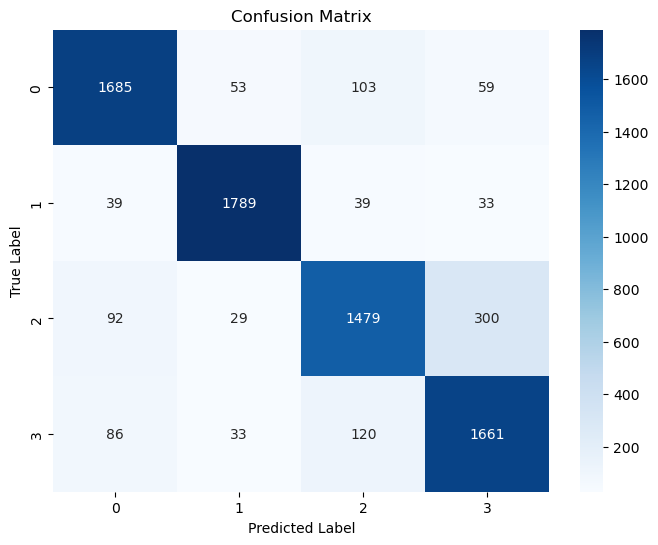

CPU times: total: 13min 27s
Wall time: 6min 34s


In [19]:
%%time

# Load the best model using the best hyperparameters found by Optuna
best_trial = study.best_trial
best_params = best_trial.params

# Build the model with the best hyperparameters
model = model_builder(best_trial)

# Train the model on the training data
model.fit([X_train_title_pad, X_train_description_pad], y_train, 
          validation_split=0.1, epochs=5, batch_size=32, verbose=0)

# Make predictions on the test data
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)  # Convert predicted probabilities to predicted classes

# Calculate accuracy
test_accuracy = (y_pred_classes == y_test).mean()
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()